# Import Library

In [1]:
# Library yang sering digunakan
import os, shutil
import gdown
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm as tq
import os
import plotly.express as px

In [2]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [3]:
!pip install gdown
!pip install split-folders

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# Data Gathering

In [6]:
!gdown https://drive.google.com/uc?id=1Ay0szCAF_aFZTjc0iObWUxB150OlugxI

Downloading...
From (original): https://drive.google.com/uc?id=1Ay0szCAF_aFZTjc0iObWUxB150OlugxI
From (redirected): https://drive.google.com/uc?id=1Ay0szCAF_aFZTjc0iObWUxB150OlugxI&confirm=t&uuid=f9165d98-8b68-44ef-a639-79d621e4d91b
To: /content/trashnet-merged.zip
100% 98.3M/98.3M [00:01<00:00, 89.2MB/s]


In [7]:
!unzip trashnet-merged.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: trashmerged/glass/brown-glass513.jpg  
  inflating: trashmerged/glass/brown-glass490.jpg  
  inflating: trashmerged/trash/trash266.jpg  
  inflating: trashmerged/glass/brown-glass511.jpg  
  inflating: trashmerged/glass/brown-glass501.jpg  
  inflating: trashmerged/glass/brown-glass57.jpg  
  inflating: trashmerged/glass/brown-glass443.jpg  
  inflating: trashmerged/glass/brown-glass600.jpg  
  inflating: trashmerged/glass/brown-glass473.jpg  
  inflating: trashmerged/glass/brown-glass499.jpg  
  inflating: trashmerged/glass/brown-glass545.jpg  
  inflating: trashmerged/glass/brown-glass46.jpg  
  inflating: trashmerged/glass/brown-glass494.jpg  
  inflating: trashmerged/glass/brown-glass493.jpg  
  inflating: trashmerged/glass/brown-glass512.jpg  
  inflating: trashmerged/glass/brown-glass483.jpg  
  inflating: trashmerged/glass/brown-glass447.jpg  
  inflating: trashmerged/glass/brown-glass58.jpg  
  inflating: t

# Data Splitting

In [8]:
import splitfolders
BASE_DIR = 'trashmerged'

# make output directory
OUTPUT_DIR = 'dataset-split'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# dataset split
splitfolders.ratio(BASE_DIR, output=OUTPUT_DIR, seed=42, ratio=(0.7, 0.15, 0.15))

Copying files: 7326 files [00:00, 7681.14 files/s]


In [9]:
splits = ['train', 'val', 'test']

for split in splits:
    split_path = os.path.join(OUTPUT_DIR, split)
    classes = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
    print(f"\nSplit: {split}")
    for class_name in classes:
        class_dir = os.path.join(split_path, class_name)
        num_images = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
        print(f"  Kelas '{class_name}': {num_images} gambar")


Split: train
  Kelas 'paper': 1150 gambar
  Kelas 'glass': 784 gambar
  Kelas 'metal': 825 gambar
  Kelas 'plastic': 942 gambar
  Kelas 'cardboard': 840 gambar
  Kelas 'trash': 583 gambar

Split: val
  Kelas 'paper': 246 gambar
  Kelas 'glass': 168 gambar
  Kelas 'metal': 176 gambar
  Kelas 'plastic': 202 gambar
  Kelas 'cardboard': 180 gambar
  Kelas 'trash': 125 gambar

Split: test
  Kelas 'paper': 248 gambar
  Kelas 'glass': 169 gambar
  Kelas 'metal': 178 gambar
  Kelas 'plastic': 203 gambar
  Kelas 'cardboard': 181 gambar
  Kelas 'trash': 126 gambar


# Image Data Generator

In [10]:
train_dir = os.path.join(OUTPUT_DIR, 'train')
val_dir = os.path.join(OUTPUT_DIR, 'val')
test_dir = os.path.join(OUTPUT_DIR, 'test')

# Augmentasi hanya untuk data train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Validation & test hanya rescale
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),   # Ubah sesuai kebutuhan
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 5124 images belonging to 6 classes.
Found 1097 images belonging to 6 classes.
Found 1105 images belonging to 6 classes.


# Data Modeling

In [11]:
# ============================================================================
# 6. MENGHITUNG CLASS WEIGHTS
# ============================================================================

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(1.0166666666666666), 1: np.float64(1.0892857142857142), 2: np.float64(1.0351515151515152), 3: np.float64(0.7426086956521739), 4: np.float64(0.9065817409766455), 5: np.float64(1.4648370497427101)}


In [12]:
def model_train(model, batch_size, epoch, phase):

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss',
                                    patience=5,
                                    restore_best_weights=True,
                                    min_delta=0.001,
                                    verbose=0)

    reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                              factor=0.5,
                                              patience=5,
                                              min_lr=1e-7,
                                              verbose=1)

    model_checkpoint = ModelCheckpoint(filepath= f'training/best_model_{phase}.h5', monitor='val_loss', save_best_only=True)

    history = model.fit(train_generator,
          epochs=epoch,
          batch_size=batch_size,
          callbacks=[early_stopping, model_checkpoint, reduce_learning_rate],
          validation_data=val_generator,
          class_weight=class_weights)

    return history

def gen_confusion_matrix(y_true, preds):
    cm = pd.DataFrame(data=confusion_matrix(y_true, preds,
                                        labels=[0, 1, 2, 3, 4, 5]), index=["Actual Cardboard", "Actual Glass", "Actual Metal", "Actual Paper", "Actual Plastic", "Actual Trash"],
                                        columns=["Predicted Cardboard", "Predicted Glass", "Predicted Metal", "Predicted Paper", "Predicted Plastic", "Predicted Trash"])

    print(classification_report(y_true=y_true,
                                y_pred=preds,
                                target_names =['Cardboard', 'Glass', 'Metal', 'paper', 'Plastic', 'Trash'], digits=4))
    print('\n\n')
    sns.heatmap(cm,annot=True,fmt="d")

In [13]:
def plot_training_history(history):
    acc = history.history['accuracy']               #Nilai akurasi training
    val_acc = history.history['val_accuracy']       #Nilai akurasi validation

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='training')
    plt.plot(epochs, val_acc, 'g', label='validation')
    plt.title('Grafik Akurasi Model')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

    loss = history.history['loss']                  #Nilai loss training
    val_loss = history.history['val_loss']          #Nilai loss validation

    plt.plot(epochs, loss, 'r', label='training')
    plt.plot(epochs, val_loss, 'y', label='validation')
    plt.title('Grafik Loss Model')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

## Baseline

In [14]:
def create_baseline_model(num_classes=6):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    base_model.trainable = False

    # Add custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [15]:
model_1 = create_baseline_model(num_classes=6)

model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_1.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,169,478 (27.35 MB)

 Trainable params: 131,974 (515.52 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [18]:
history_phase1 = model_train(model=model_1, batch_size=16, epoch=50, phase='baseline')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5332 - loss: 1.2450

321/321 ━━━━━━━━━━━━━━━━━━━━ 1012s 3s/step - accuracy: 0.5336 - loss: 1.2441 - val_accuracy: 0.8286 - val_loss: 0.5102 - learning_rate: 0.0010
Epoch 2/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7731 - loss: 0.6340

321/321 ━━━━━━━━━━━━━━━━━━━━ 964s 3s/step - accuracy: 0.7731 - loss: 0.6339 - val_accuracy: 0.8432 - val_loss: 0.4340 - learning_rate: 0.0010
Epoch 3/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8044 - loss: 0.5429

321/321 ━━━━━━━━━━━━━━━━━━━━ 950s 3s/step - accuracy: 0.8044 - loss: 0.5429 - val_accuracy: 0.8778 - val_loss: 0.3812 - learning_rate: 0.0010
Epoch 4/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8243 - loss: 0.4739

321/321 ━━━━━━━━━━━━━━━━━━━━ 947s 3s/step - accuracy: 0.8243 - loss: 0.4739 - val_accuracy: 0.8861 - val_loss: 0.3551 - learning_rate: 0.0010
Epoch 5/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8431 - loss: 0.4480

321/321 ━━━━━━━━━━━━━━━━━━━━ 952s 3s/step - accuracy: 0.8431 - loss: 0.4480 - val_accuracy: 0.8861 - val_loss: 0.3351 - learning_rate: 0.0010
Epoch 6/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8510 - loss: 0.4072

321/321 ━━━━━━━━━━━━━━━━━━━━ 976s 3s/step - accuracy: 0.8510 - loss: 0.4072 - val_accuracy: 0.8833 - val_loss: 0.3340 - learning_rate: 0.0010
Epoch 7/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8689 - loss: 0.3801

321/321 ━━━━━━━━━━━━━━━━━━━━ 944s 3s/step - accuracy: 0.8689 - loss: 0.3801 - val_accuracy: 0.8943 - val_loss: 0.3146 - learning_rate: 0.0010
Epoch 8/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 945s 3s/step - accuracy: 0.8738 - loss: 0.3618 - val_accuracy: 0.8833 - val_loss: 0.3618 - learning_rate: 0.0010
Epoch 9/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 991s 3s/step - accuracy: 0.8737 - loss: 0.3459 - val_accuracy: 0.8952 - val_loss: 0.3207 - learning_rate: 0.0010
Epoch 10/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8761 - loss: 0.3369

321/321 ━━━━━━━━━━━━━━━━━━━━ 1005s 3s/step - accuracy: 0.8761 - loss: 0.3369 - val_accuracy: 0.8970 - val_loss: 0.3136 - learning_rate: 0.0010
Epoch 11/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8876 - loss: 0.3045

321/321 ━━━━━━━━━━━━━━━━━━━━ 944s 3s/step - accuracy: 0.8876 - loss: 0.3045 - val_accuracy: 0.8997 - val_loss: 0.2829 - learning_rate: 0.0010
Epoch 12/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 938s 3s/step - accuracy: 0.8948 - loss: 0.2939 - val_accuracy: 0.8970 - val_loss: 0.2962 - learning_rate: 0.0010
Epoch 13/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 943s 3s/step - accuracy: 0.8961 - loss: 0.2897 - val_accuracy: 0.8988 - val_loss: 0.2950 - learning_rate: 0.0010
Epoch 14/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 940s 3s/step - accuracy: 0.8913 - loss: 0.2884 - val_accuracy: 0.8952 - val_loss: 0.3001 - learning_rate: 0.0010
Epoch 15/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8943 - loss: 0.2882

321/321 ━━━━━━━━━━━━━━━━━━━━ 944s 3s/step - accuracy: 0.8943 - loss: 0.2882 - val_accuracy: 0.9052 - val_loss: 0.2815 - learning_rate: 0.0010
Epoch 16/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 950s 3s/step - accuracy: 0.9051 - loss: 0.2663 - val_accuracy: 0.9079 - val_loss: 0.2901 - learning_rate: 0.0010
Epoch 17/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9028 - loss: 0.2694

321/321 ━━━━━━━━━━━━━━━━━━━━ 990s 3s/step - accuracy: 0.9028 - loss: 0.2694 - val_accuracy: 0.9143 - val_loss: 0.2581 - learning_rate: 0.0010
Epoch 18/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 999s 3s/step - accuracy: 0.9098 - loss: 0.2328 - val_accuracy: 0.9098 - val_loss: 0.2752 - learning_rate: 0.0010
Epoch 19/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 928s 3s/step - accuracy: 0.9035 - loss: 0.2560 - val_accuracy: 0.9070 - val_loss: 0.2926 - learning_rate: 0.0010
Epoch 20/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 927s 3s/step - accuracy: 0.9212 - loss: 0.2331 - val_accuracy: 0.9070 - val_loss: 0.2987 - learning_rate: 0.0010
Epoch 21/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 942s 3s/step - accuracy: 0.9141 - loss: 0.2276 - val_accuracy: 0.9107 - val_loss: 0.2654 - learning_rate: 0.0010
Epoch 22/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9253 - loss: 0.2068
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
321/321 ━━━━━━━━━━━━━━━━━━━━ 934s 3s/step - accuracy: 0.9253 - loss: 0.2069 - v

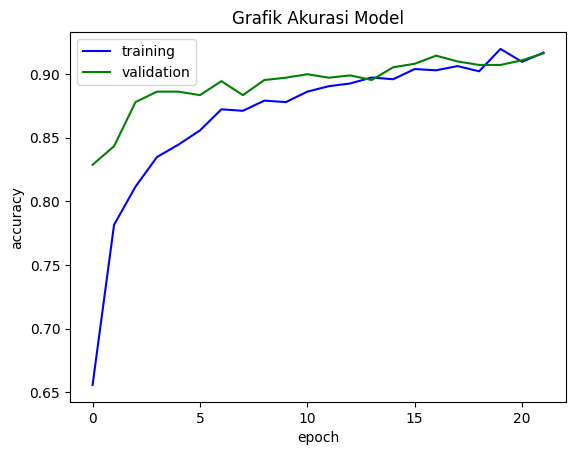

<Figure size 640x480 with 0 Axes>

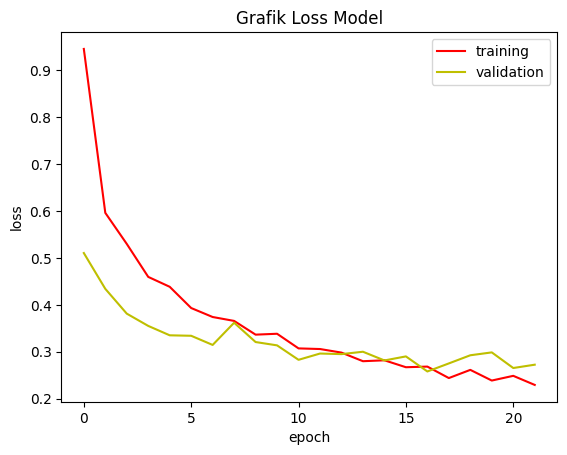

<Figure size 640x480 with 0 Axes>

In [19]:
plot_training_history(history_phase1)

## Fine Tuning

In [ ]:
# ============================================================================
# 4. IMPROVED MODEL ARCHITECTURE
# ============================================================================

def create_finetune_model(num_classes=6):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # --- Add custom head ---
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)  # Meningkatkan neurons
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu') (x)
    x = Dropout(0.1)(x)
    predictions = Dense(6, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # --- Fine tuning setup ---
    # Unfreeze all layers (fine tuning the whole model)
    for layer in base_model.layers:
        layer.trainable = True

    return model

In [ ]:
model_2 = create_finetune_model(num_classes=6)

# --- Compile model with SGD + Nesterov momentum ---
optimizer_sgd = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)

model_2.compile(optimizer=optimizer_sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_2.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,177,862 (27.38 MB)

 Trainable params: 7,093,958 (27.06 MB)

 Non-trainable params: 83,904 (327.75 KB)

In [ ]:
history_phase2 = model_train(model_2, 16, 50, 'finetuning')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.2710 - loss: 1.8940

321/321 ━━━━━━━━━━━━━━━━━━━━ 388s 787ms/step - accuracy: 0.2713 - loss: 1.8933 - val_accuracy: 0.6454 - val_loss: 1.0109 - learning_rate: 1.0000e-04
Epoch 2/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.5492 - loss: 1.1807

321/321 ━━━━━━━━━━━━━━━━━━━━ 135s 294ms/step - accuracy: 0.5493 - loss: 1.1804 - val_accuracy: 0.7621 - val_loss: 0.7172 - learning_rate: 1.0000e-04
Epoch 3/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.6658 - loss: 0.9112

321/321 ━━━━━━━━━━━━━━━━━━━━ 94s 292ms/step - accuracy: 0.6659 - loss: 0.9110 - val_accuracy: 0.8368 - val_loss: 0.5231 - learning_rate: 1.0000e-04
Epoch 4/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.7324 - loss: 0.7615

321/321 ━━━━━━━━━━━━━━━━━━━━ 95s 296ms/step - accuracy: 0.7325 - loss: 0.7615 - val_accuracy: 0.8377 - val_loss: 0.5111 - learning_rate: 1.0000e-04
Epoch 5/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.7784 - loss: 0.6579

321/321 ━━━━━━━━━━━━━━━━━━━━ 93s 289ms/step - accuracy: 0.7784 - loss: 0.6578 - val_accuracy: 0.8769 - val_loss: 0.3742 - learning_rate: 1.0000e-04
Epoch 6/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.7967 - loss: 0.5816

321/321 ━━━━━━━━━━━━━━━━━━━━ 94s 293ms/step - accuracy: 0.7967 - loss: 0.5816 - val_accuracy: 0.8979 - val_loss: 0.3364 - learning_rate: 1.0000e-04
Epoch 7/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.8207 - loss: 0.5156

321/321 ━━━━━━━━━━━━━━━━━━━━ 95s 295ms/step - accuracy: 0.8208 - loss: 0.5156 - val_accuracy: 0.8979 - val_loss: 0.3277 - learning_rate: 1.0000e-04
Epoch 8/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.8469 - loss: 0.4648

321/321 ━━━━━━━━━━━━━━━━━━━━ 95s 295ms/step - accuracy: 0.8469 - loss: 0.4648 - val_accuracy: 0.9070 - val_loss: 0.2874 - learning_rate: 1.0000e-04
Epoch 9/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.8608 - loss: 0.4110

321/321 ━━━━━━━━━━━━━━━━━━━━ 95s 294ms/step - accuracy: 0.8607 - loss: 0.4110 - val_accuracy: 0.9098 - val_loss: 0.2814 - learning_rate: 1.0000e-04
Epoch 10/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.8467 - loss: 0.4352

321/321 ━━━━━━━━━━━━━━━━━━━━ 95s 295ms/step - accuracy: 0.8467 - loss: 0.4351 - val_accuracy: 0.9280 - val_loss: 0.2342 - learning_rate: 1.0000e-04
Epoch 11/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.8746 - loss: 0.3758

321/321 ━━━━━━━━━━━━━━━━━━━━ 93s 289ms/step - accuracy: 0.8746 - loss: 0.3758 - val_accuracy: 0.9325 - val_loss: 0.2134 - learning_rate: 1.0000e-04
Epoch 12/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 94s 292ms/step - accuracy: 0.8838 - loss: 0.3621 - val_accuracy: 0.9298 - val_loss: 0.2260 - learning_rate: 1.0000e-04
Epoch 13/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.8965 - loss: 0.3222

321/321 ━━━━━━━━━━━━━━━━━━━━ 93s 288ms/step - accuracy: 0.8965 - loss: 0.3222 - val_accuracy: 0.9389 - val_loss: 0.1866 - learning_rate: 1.0000e-04
Epoch 14/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 142s 287ms/step - accuracy: 0.9049 - loss: 0.2965 - val_accuracy: 0.9243 - val_loss: 0.2313 - learning_rate: 1.0000e-04
Epoch 15/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 92s 286ms/step - accuracy: 0.9022 - loss: 0.2894 - val_accuracy: 0.9335 - val_loss: 0.1896 - learning_rate: 1.0000e-04
Epoch 16/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 92s 286ms/step - accuracy: 0.8992 - loss: 0.2967 - val_accuracy: 0.9335 - val_loss: 0.2034 - learning_rate: 1.0000e-04
Epoch 17/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9055 - loss: 0.2908

321/321 ━━━━━━━━━━━━━━━━━━━━ 93s 290ms/step - accuracy: 0.9056 - loss: 0.2908 - val_accuracy: 0.9407 - val_loss: 0.1760 - learning_rate: 1.0000e-04
Epoch 18/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9134 - loss: 0.2546

321/321 ━━━━━━━━━━━━━━━━━━━━ 93s 289ms/step - accuracy: 0.9134 - loss: 0.2546 - val_accuracy: 0.9499 - val_loss: 0.1562 - learning_rate: 1.0000e-04
Epoch 19/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9315 - loss: 0.2190

321/321 ━━━━━━━━━━━━━━━━━━━━ 93s 290ms/step - accuracy: 0.9315 - loss: 0.2190 - val_accuracy: 0.9581 - val_loss: 0.1395 - learning_rate: 1.0000e-04
Epoch 20/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 92s 285ms/step - accuracy: 0.9284 - loss: 0.2171 - val_accuracy: 0.9526 - val_loss: 0.1422 - learning_rate: 1.0000e-04
Epoch 21/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 145s 294ms/step - accuracy: 0.9325 - loss: 0.2110 - val_accuracy: 0.9535 - val_loss: 0.1440 - learning_rate: 1.0000e-04
Epoch 22/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9406 - loss: 0.1885

321/321 ━━━━━━━━━━━━━━━━━━━━ 94s 292ms/step - accuracy: 0.9406 - loss: 0.1885 - val_accuracy: 0.9544 - val_loss: 0.1372 - learning_rate: 1.0000e-04
Epoch 23/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 94s 293ms/step - accuracy: 0.9266 - loss: 0.2193 - val_accuracy: 0.9508 - val_loss: 0.1557 - learning_rate: 1.0000e-04
Epoch 24/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9397 - loss: 0.1926

321/321 ━━━━━━━━━━━━━━━━━━━━ 93s 290ms/step - accuracy: 0.9397 - loss: 0.1926 - val_accuracy: 0.9599 - val_loss: 0.1214 - learning_rate: 1.0000e-04
Epoch 25/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 144s 296ms/step - accuracy: 0.9526 - loss: 0.1530 - val_accuracy: 0.9380 - val_loss: 0.1962 - learning_rate: 1.0000e-04
Epoch 26/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 103s 320ms/step - accuracy: 0.9416 - loss: 0.1844 - val_accuracy: 0.9517 - val_loss: 0.1422 - learning_rate: 1.0000e-04
Epoch 27/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 103s 321ms/step - accuracy: 0.9462 - loss: 0.1599 - val_accuracy: 0.9562 - val_loss: 0.1387 - learning_rate: 1.0000e-04
Epoch 28/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9527 - loss: 0.1433

321/321 ━━━━━━━━━━━━━━━━━━━━ 97s 301ms/step - accuracy: 0.9527 - loss: 0.1434 - val_accuracy: 0.9599 - val_loss: 0.1169 - learning_rate: 1.0000e-04
Epoch 29/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9514 - loss: 0.1517

321/321 ━━━━━━━━━━━━━━━━━━━━ 95s 296ms/step - accuracy: 0.9514 - loss: 0.1517 - val_accuracy: 0.9617 - val_loss: 0.1107 - learning_rate: 1.0000e-04
Epoch 30/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 95s 296ms/step - accuracy: 0.9509 - loss: 0.1453 - val_accuracy: 0.9599 - val_loss: 0.1245 - learning_rate: 1.0000e-04
Epoch 31/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 92s 287ms/step - accuracy: 0.9629 - loss: 0.1222 - val_accuracy: 0.9572 - val_loss: 0.1237 - learning_rate: 1.0000e-04
Epoch 32/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 94s 291ms/step - accuracy: 0.9588 - loss: 0.1209 - val_accuracy: 0.9635 - val_loss: 0.1133 - learning_rate: 1.0000e-04
Epoch 33/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9559 - loss: 0.1338

321/321 ━━━━━━━━━━━━━━━━━━━━ 94s 293ms/step - accuracy: 0.9559 - loss: 0.1337 - val_accuracy: 0.9708 - val_loss: 0.1086 - learning_rate: 1.0000e-04
Epoch 34/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9606 - loss: 0.1229

321/321 ━━━━━━━━━━━━━━━━━━━━ 94s 292ms/step - accuracy: 0.9606 - loss: 0.1229 - val_accuracy: 0.9717 - val_loss: 0.0974 - learning_rate: 1.0000e-04
Epoch 35/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 93s 288ms/step - accuracy: 0.9646 - loss: 0.1094 - val_accuracy: 0.9644 - val_loss: 0.1005 - learning_rate: 1.0000e-04
Epoch 36/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 93s 290ms/step - accuracy: 0.9648 - loss: 0.1101 - val_accuracy: 0.9663 - val_loss: 0.1089 - learning_rate: 1.0000e-04
Epoch 37/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 92s 286ms/step - accuracy: 0.9654 - loss: 0.0993 - val_accuracy: 0.9699 - val_loss: 0.1009 - learning_rate: 1.0000e-04
Epoch 38/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 94s 292ms/step - accuracy: 0.9687 - loss: 0.1124 - val_accuracy: 0.9663 - val_loss: 0.1035 - learning_rate: 1.0000e-04
Epoch 39/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9686 - loss: 0.0933
Epoch 39: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
321/321 ━━━━━━━━━━━━━━━━━━━━ 93s 291ms/step - 

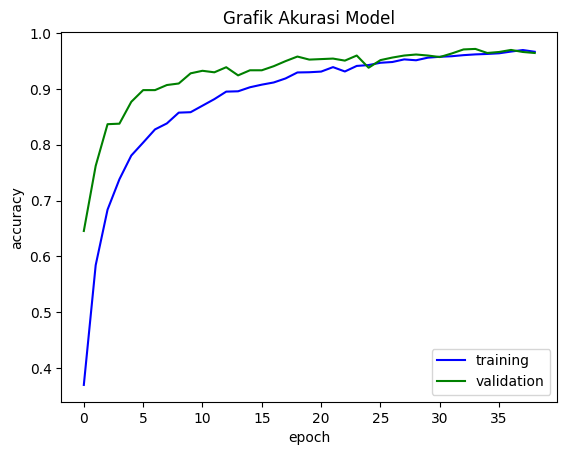

<Figure size 640x480 with 0 Axes>

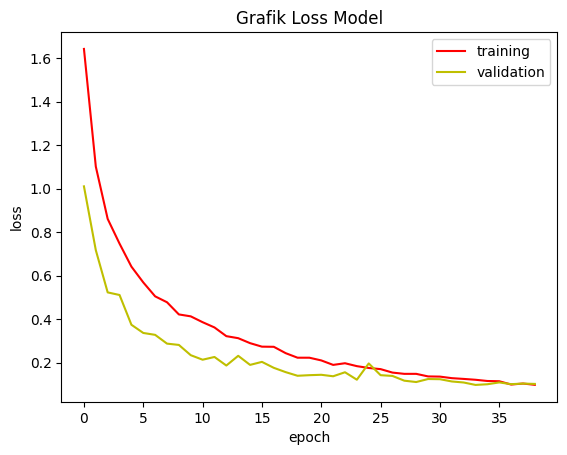

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_training_history(history_phase2)

# Evaluation


Test Accuracy: 0.9167
35/35 ━━━━━━━━━━━━━━━━━━━━ 177s 5s/step


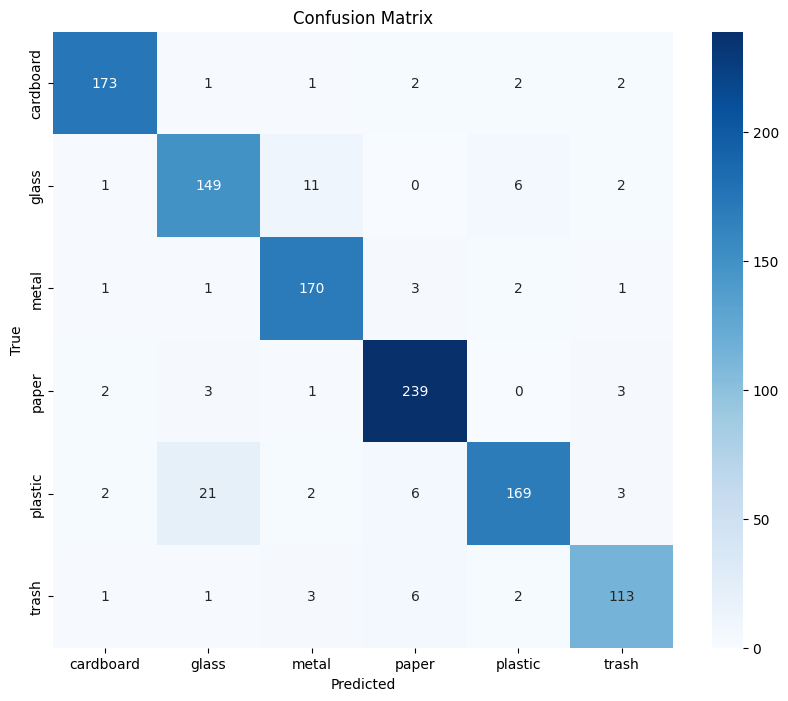


Classification Report:
              precision    recall  f1-score   support

   cardboard       0.96      0.96      0.96       181
       glass       0.85      0.88      0.86       169
       metal       0.90      0.96      0.93       178
       paper       0.93      0.96      0.95       248
     plastic       0.93      0.83      0.88       203
       trash       0.91      0.90      0.90       126

    accuracy                           0.92      1105
   macro avg       0.92      0.91      0.91      1105
weighted avg       0.92      0.92      0.92      1105



In [21]:
# EVALUATION FOR BASELINE
# Evaluate on test set
test_loss, test_accuracy = model_1.evaluate(test_generator, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Predictions for confusion matrix
test_generator.reset()  # Reset generator
predictions = model_1.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


Test Accuracy: 0.9765
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 409ms/step


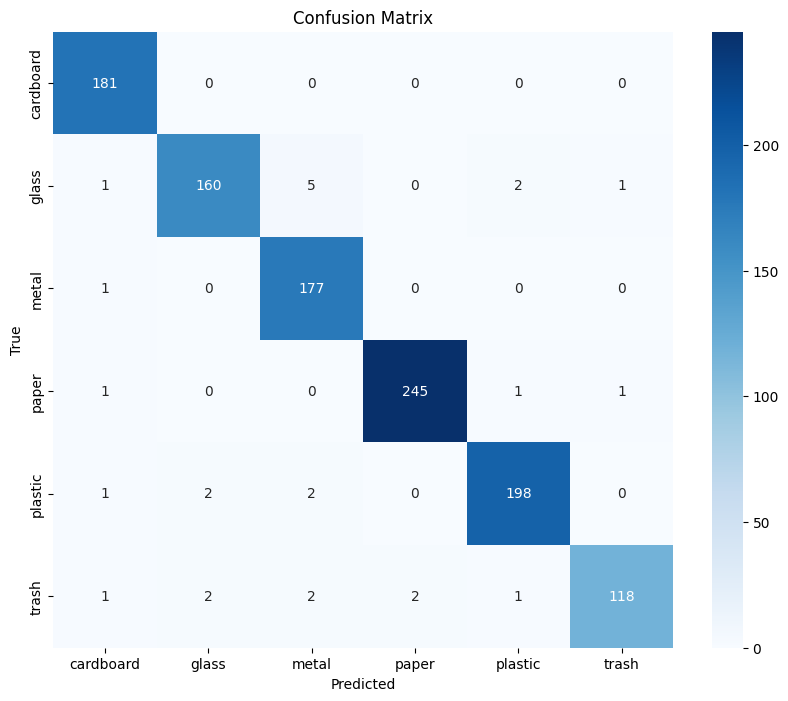


Classification Report:
              precision    recall  f1-score   support

   cardboard       0.97      1.00      0.99       181
       glass       0.98      0.95      0.96       169
       metal       0.95      0.99      0.97       178
       paper       0.99      0.99      0.99       248
     plastic       0.98      0.98      0.98       203
       trash       0.98      0.94      0.96       126

    accuracy                           0.98      1105
   macro avg       0.98      0.97      0.97      1105
weighted avg       0.98      0.98      0.98      1105



In [ ]:
# EVALUATION FOR FINE-TUNING
# Evaluate on test set
test_loss, test_accuracy = model_2.evaluate(test_generator, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Predictions for confusion matrix
test_generator.reset()  # Reset generator
predictions = model_2.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Eksperimen

In [22]:
# ============================================================================
# 1. SINGLE IMAGE PREDICTION EXPERIMENT
# ============================================================================

def predict_single_image(model, img_path, class_names, img_size=(224, 224)):

    # preprocess image
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # prediction
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    return {
        'image': img,
        'predictions': predictions[0],
        'predicted_class': class_names[predicted_class_idx],
        'confidence': confidence,
        'class_idx': predicted_class_idx
    }

def plot_single_prediction(result, class_names, true_label=None):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot image
    ax1.imshow(result['image'])
    ax1.axis('off')

    # Title with prediction
    title = f"Predicted: {result['predicted_class']}\nConfidence: {result['confidence']:.2%}"
    if true_label:
        color = 'green' if result['predicted_class'] == true_label else 'red'
        title += f"\nTrue: {true_label}"
        ax1.set_title(title, color=color, fontsize=12)
    else:
        ax1.set_title(title, fontsize=12)

    # Plot confidence scores
    bars = ax2.bar(range(len(class_names)), result['predictions'])
    ax2.set_xlabel('Classes')
    ax2.set_ylabel('Confidence')
    ax2.set_title('Prediction Confidence')
    ax2.set_xticks(range(len(class_names)))
    ax2.set_xticklabels(class_names, rotation=45, ha='right')

    # Highlight predicted class
    bars[result['class_idx']].set_color('red')

    # Add confidence values on bars
    for i, (bar, conf) in enumerate(zip(bars, result['predictions'])):
        if conf > 0.01:  # Only show if confidence > 1%
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{conf:.2%}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

In [23]:
# ============================================================================
# 2. BATCH PREDICTION EXPERIMENT
# ============================================================================

def sample_images_from_each_class(test_dir, class_names, n_samples=2):
    """
    Sample n images from each class for testing
    """
    sampled_images = []

    for class_name in class_names:
        class_path = os.path.join(test_dir, class_name)
        if not os.path.exists(class_path):
            continue

        # Get all image files
        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Sample n images
        sample_files = random.sample(image_files, min(n_samples, len(image_files)))

        for img_file in sample_files:
            sampled_images.append({
                'path': os.path.join(class_path, img_file),
                'true_class': class_name,
                'filename': img_file
            })

    return sampled_images

def batch_prediction_experiment(model, test_dir, class_names, n_samples=2):
    """
    Run batch prediction experiment
    """
    # Sample images
    sampled_images = sample_images_from_each_class(test_dir, class_names, n_samples)

    # Make predictions
    results = []
    for img_info in sampled_images:
        result = predict_single_image(model, img_info['path'], class_names)
        result['true_class'] = img_info['true_class']
        result['filename'] = img_info['filename']
        result['correct'] = result['predicted_class'] == result['true_class']
        results.append(result)

    return results

def plot_batch_predictions(results, class_names, cols=4):
    """
    Plot batch prediction results in grid
    """
    n_images = len(results)
    rows = (n_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()

    for i, result in enumerate(results):
        if i >= len(axes):
            break

        ax = axes[i]

        # Plot image
        ax.imshow(result['image'])
        ax.axis('off')

        color = 'green' if result['correct'] else 'red'
        title = f"True: {result['true_class']}\nPred: {result['predicted_class']}\nConf: {result['confidence']:.2%}"
        ax.set_title(title, color=color, fontsize=10)

    for i in range(len(results), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    correct_predictions = sum(1 for r in results if r['correct'])
    accuracy = correct_predictions / len(results)
    print(f"\nBatch Prediction Summary:")
    print(f"Total images: {len(results)}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy:.2%}")

In [24]:
# ============================================================================
# 3. CONFIDENCE ANALYSIS EXPERIMENT
# ============================================================================

def confidence_analysis(results):
    """
    Analyze prediction confidence patterns
    """
    confidences = [r['confidence'] for r in results]
    correct_confidences = [r['confidence'] for r in results if r['correct']]
    incorrect_confidences = [r['confidence'] for r in results if not r['correct']]

    plt.figure(figsize=(12, 4))

    # Histogram of all confidences
    plt.subplot(1, 3, 1)
    plt.hist(confidences, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.title('All Predictions Confidence')
    plt.axvline(np.mean(confidences), color='red', linestyle='--',
                label=f'Mean: {np.mean(confidences):.2%}')
    plt.legend()

    # Correct vs Incorrect confidence comparison
    plt.subplot(1, 3, 2)
    if correct_confidences:
        plt.hist(correct_confidences, bins=15, alpha=0.7, color='green', label='Correct')
    if incorrect_confidences:
        plt.hist(incorrect_confidences, bins=15, alpha=0.7, color='red', label='Incorrect')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.title('Confidence: Correct vs Incorrect')
    plt.legend()

    # Box plot
    plt.subplot(1, 3, 3)
    data_to_plot = []
    labels = []
    if correct_confidences:
        data_to_plot.append(correct_confidences)
        labels.append('Correct')
    if incorrect_confidences:
        data_to_plot.append(incorrect_confidences)
        labels.append('Incorrect')

    if data_to_plot:
        plt.boxplot(data_to_plot, labels=labels)
        plt.ylabel('Confidence')
        plt.title('Confidence Distribution')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\nConfidence Analysis:")
    print(f"Average confidence (all): {np.mean(confidences):.2%}")
    if correct_confidences:
        print(f"Average confidence (correct): {np.mean(correct_confidences):.2%}")
    if incorrect_confidences:
        print(f"Average confidence (incorrect): {np.mean(incorrect_confidences):.2%}")

In [25]:
# ============================================================================
# 4. CLASS-WISE PERFORMANCE EXPERIMENT
# ============================================================================

def class_wise_performance(results, class_names):
    class_stats = {}

    for class_name in class_names:
        class_results = [r for r in results if r['true_class'] == class_name]
        if class_results:
            correct = sum(1 for r in class_results if r['correct'])
            total = len(class_results)
            avg_confidence = np.mean([r['confidence'] for r in class_results])

            class_stats[class_name] = {
                'total': total,
                'correct': correct,
                'accuracy': correct / total,
                'avg_confidence': avg_confidence
            }

    # Plot class-wise accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    classes = list(class_stats.keys())
    accuracies = [class_stats[c]['accuracy'] for c in classes]
    bars = plt.bar(classes, accuracies)
    plt.xlabel('Classes')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Class')
    plt.xticks(rotation=45, ha='right')

    # Color bars based on accuracy
    for bar, acc in zip(bars, accuracies):
        if acc >= 0.8:
            bar.set_color('green')
        elif acc >= 0.6:
            bar.set_color('orange')
        else:
            bar.set_color('red')

    # Add accuracy values on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.1%}', ha='center', va='bottom')

    plt.subplot(1, 2, 2)
    confidences = [class_stats[c]['avg_confidence'] for c in classes]
    plt.bar(classes, confidences, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Average Confidence')
    plt.title('Average Confidence per Class')
    plt.xticks(rotation=45, ha='right')

    # Add confidence values on bars
    for i, (cls, conf) in enumerate(zip(classes, confidences)):
        plt.text(i, conf + 0.01, f'{conf:.1%}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Print detailed stats
    print("\nClass-wise Performance:")
    print("-" * 60)
    for class_name, stats in class_stats.items():
        print(f"{class_name:15} | Accuracy: {stats['accuracy']:5.1%} | "
              f"Confidence: {stats['avg_confidence']:5.1%} | "
              f"Samples: {stats['total']:2d}")

In [26]:
# ============================================================================
# 5. MAIN EXPERIMENT RUNNER
# ============================================================================

def run_comprehensive_experiments(model, test_dir, class_names, n_samples=3):
    """
    Run all experiments
    """
    print("🔬 Starting Comprehensive Model Experiments...")
    print("=" * 60)

    # Set random seed for reproducible sampling
    random.seed(42)

    print("1️ Running Batch Prediction Experiment...")
    results = batch_prediction_experiment(model, test_dir, class_names, n_samples)
    plot_batch_predictions(results, class_names)

    print("\n2️ Analyzing Prediction Confidence...")
    confidence_analysis(results)

    print("\n3️ Evaluating Class-wise Performance...")
    class_wise_performance(results, class_names)

    print("\n All experiments completed!")

    return results

In [27]:
# ============================================================================
# 6. INTERACTIVE PREDICTION FUNCTION
# ============================================================================

def interactive_prediction(model, class_names):
    """
    Interactive prediction function (for manual testing)
    """
    print("🎯 Interactive Prediction Mode")
    print("Enter image path to predict (or 'quit' to exit):")

    while True:
        img_path = input("\nImage path: ").strip()

        if img_path.lower() in ['quit', 'exit', 'q']:
            break

        if not os.path.exists(img_path):
            print("File not found!")
            continue

        try:
            result = predict_single_image(model, img_path, class_names)
            plot_single_prediction(result, class_names)

            print(f" Prediction: {result['predicted_class']}")
            print(f"Confidence: {result['confidence']:.2%}")

        except Exception as e:
            print(f"Error processing image: {e}")

🔬 Starting Comprehensive Model Experiments...
1️ Running Batch Prediction Experiment...


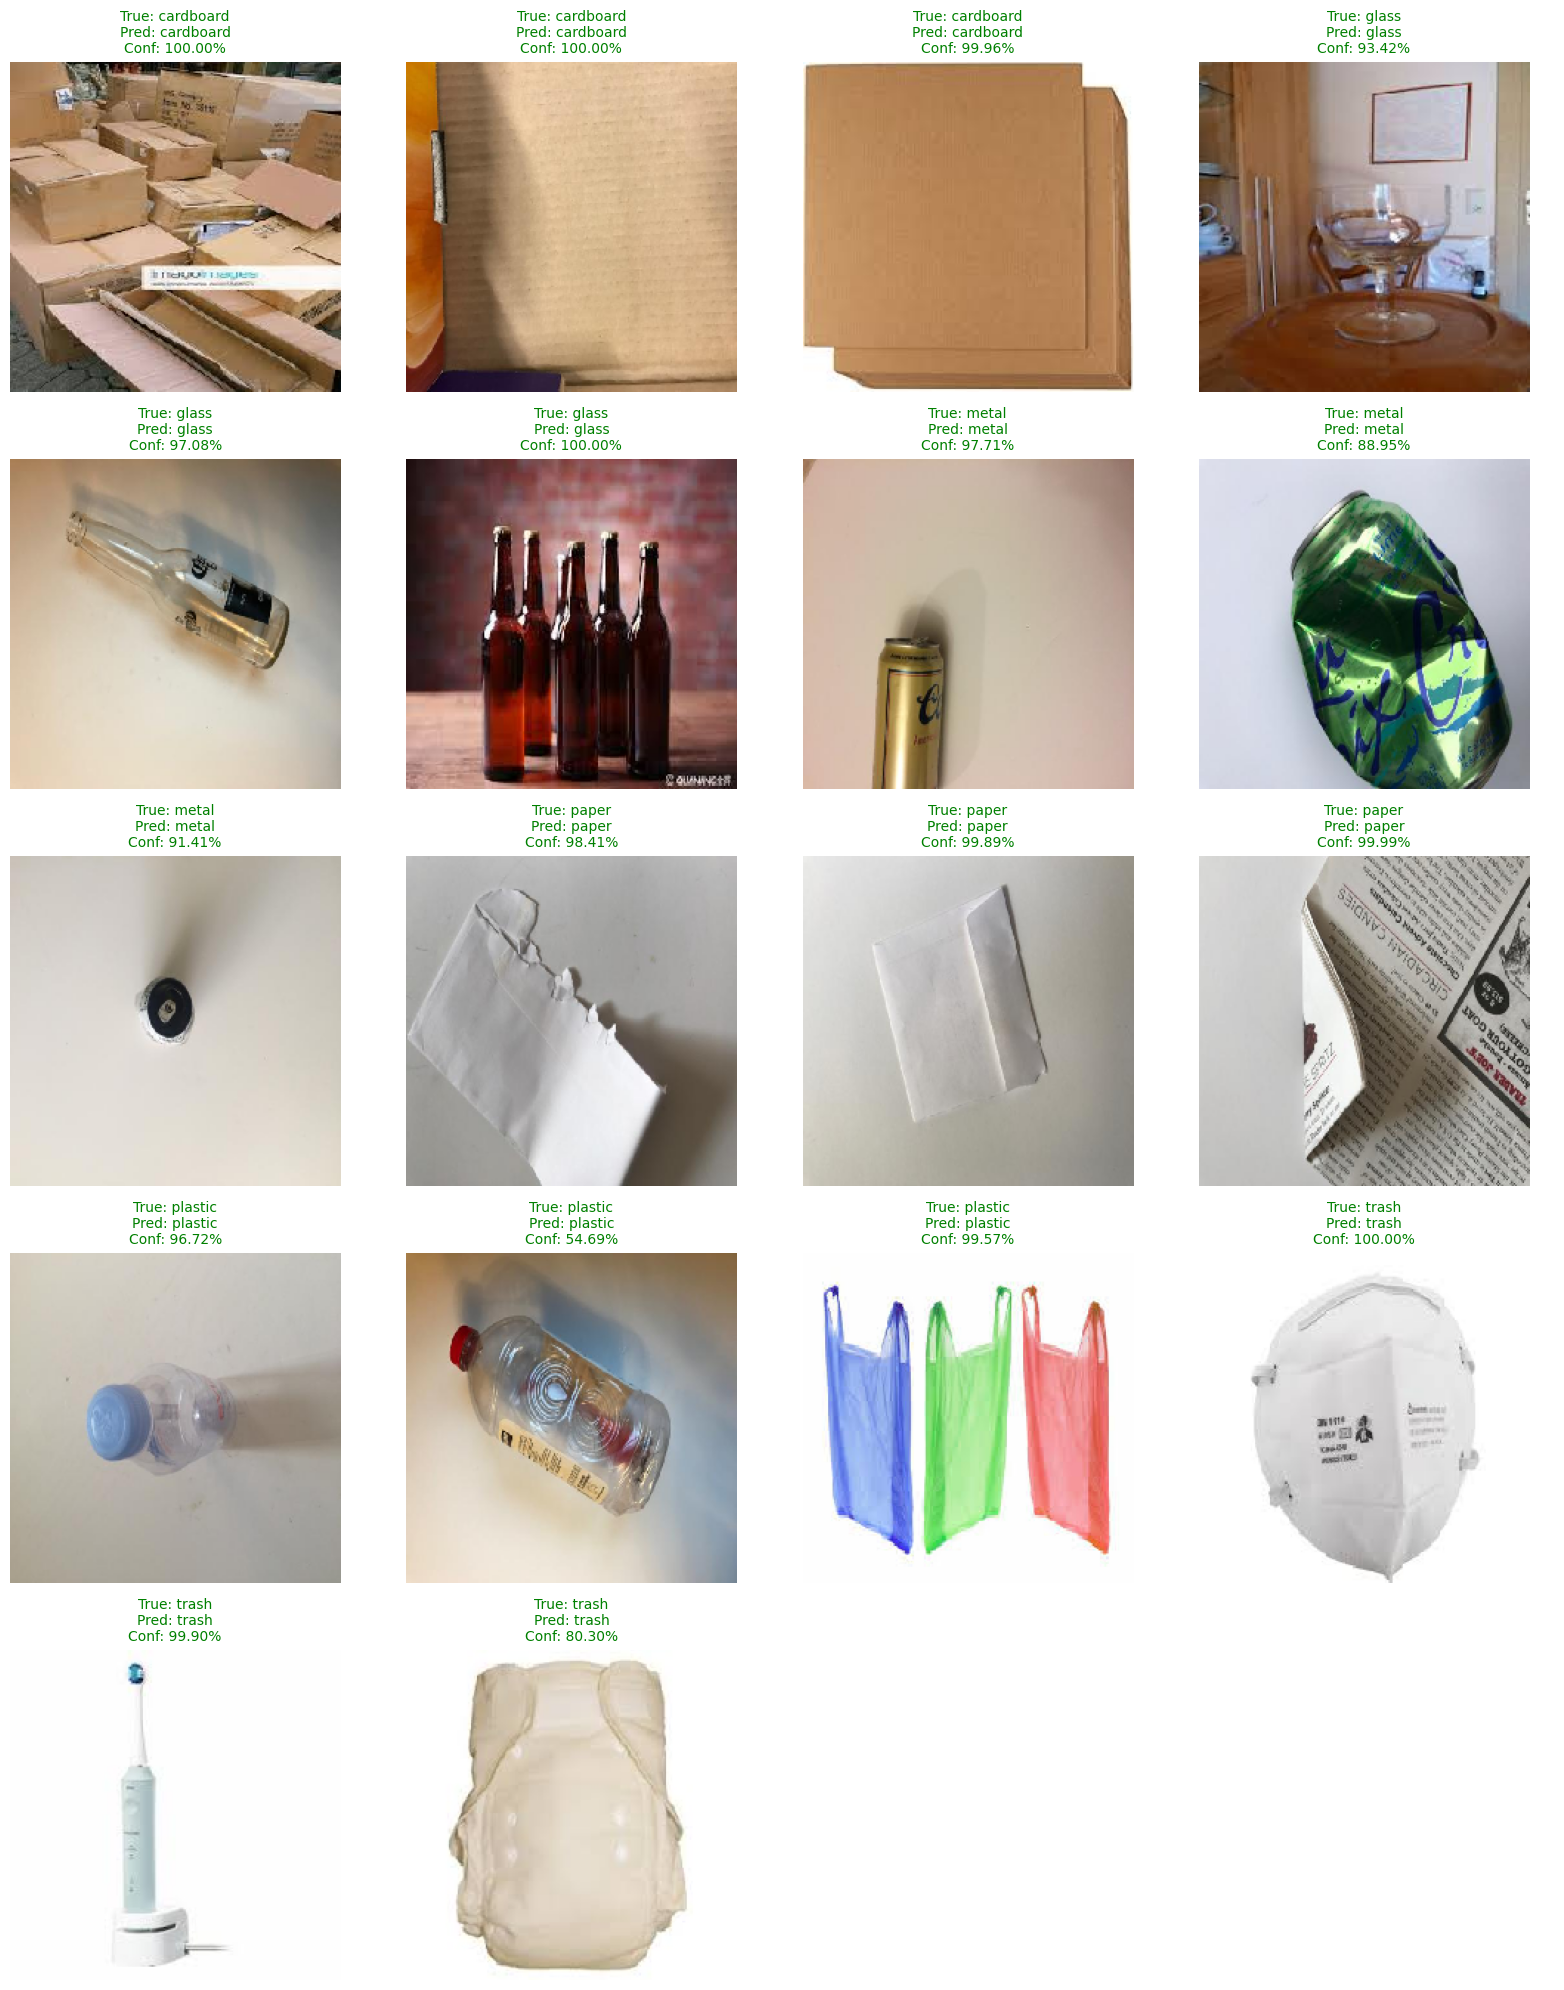


Batch Prediction Summary:
Total images: 18
Correct predictions: 18
Accuracy: 100.00%

2️ Analyzing Prediction Confidence...


<ipython-input-24-44a42ea638cf>:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels)


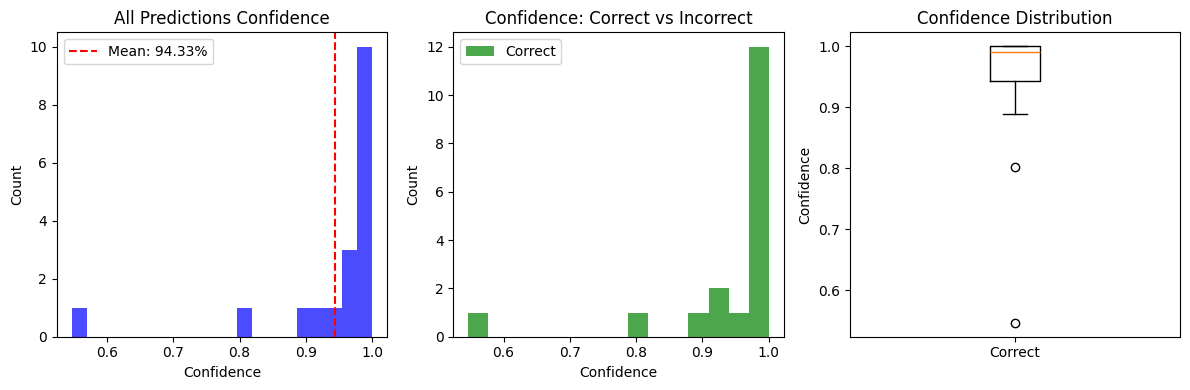


Confidence Analysis:
Average confidence (all): 94.33%
Average confidence (correct): 94.33%

3️ Evaluating Class-wise Performance...


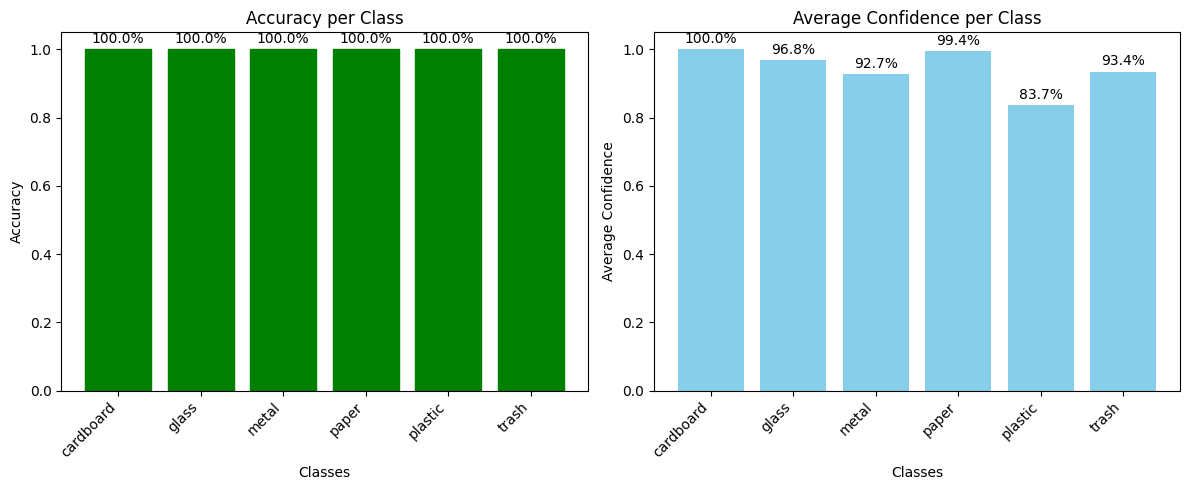


Class-wise Performance:
------------------------------------------------------------
cardboard       | Accuracy: 100.0% | Confidence: 100.0% | Samples:  3
glass           | Accuracy: 100.0% | Confidence: 96.8% | Samples:  3
metal           | Accuracy: 100.0% | Confidence: 92.7% | Samples:  3
paper           | Accuracy: 100.0% | Confidence: 99.4% | Samples:  3
plastic         | Accuracy: 100.0% | Confidence: 83.7% | Samples:  3
trash           | Accuracy: 100.0% | Confidence: 93.4% | Samples:  3

 All experiments completed!
📋 Experiment functions sukses!
Use run_comprehensive_experiments() to start testing your model.


In [29]:
# ============================================================================
# CARA PENGGUNAAN MENGGUNAKAN MODEL BASELINE
# ============================================================================

import random

# 1. Load your trained model
model = tf.keras.models.load_model('training/best_model_baseline.h5')

# 2. Define class names (should match your training data)
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# 3. Define test directory
test_dir = 'dataset-split/test'

# 4. Run comprehensive experiments
results = run_comprehensive_experiments(model, test_dir, class_names, n_samples=3)


print("📋 Experiment functions sukses!")
print("Use run_comprehensive_experiments() to start testing your model.")

🔬 Starting Comprehensive Model Experiments...
1️ Running Batch Prediction Experiment...


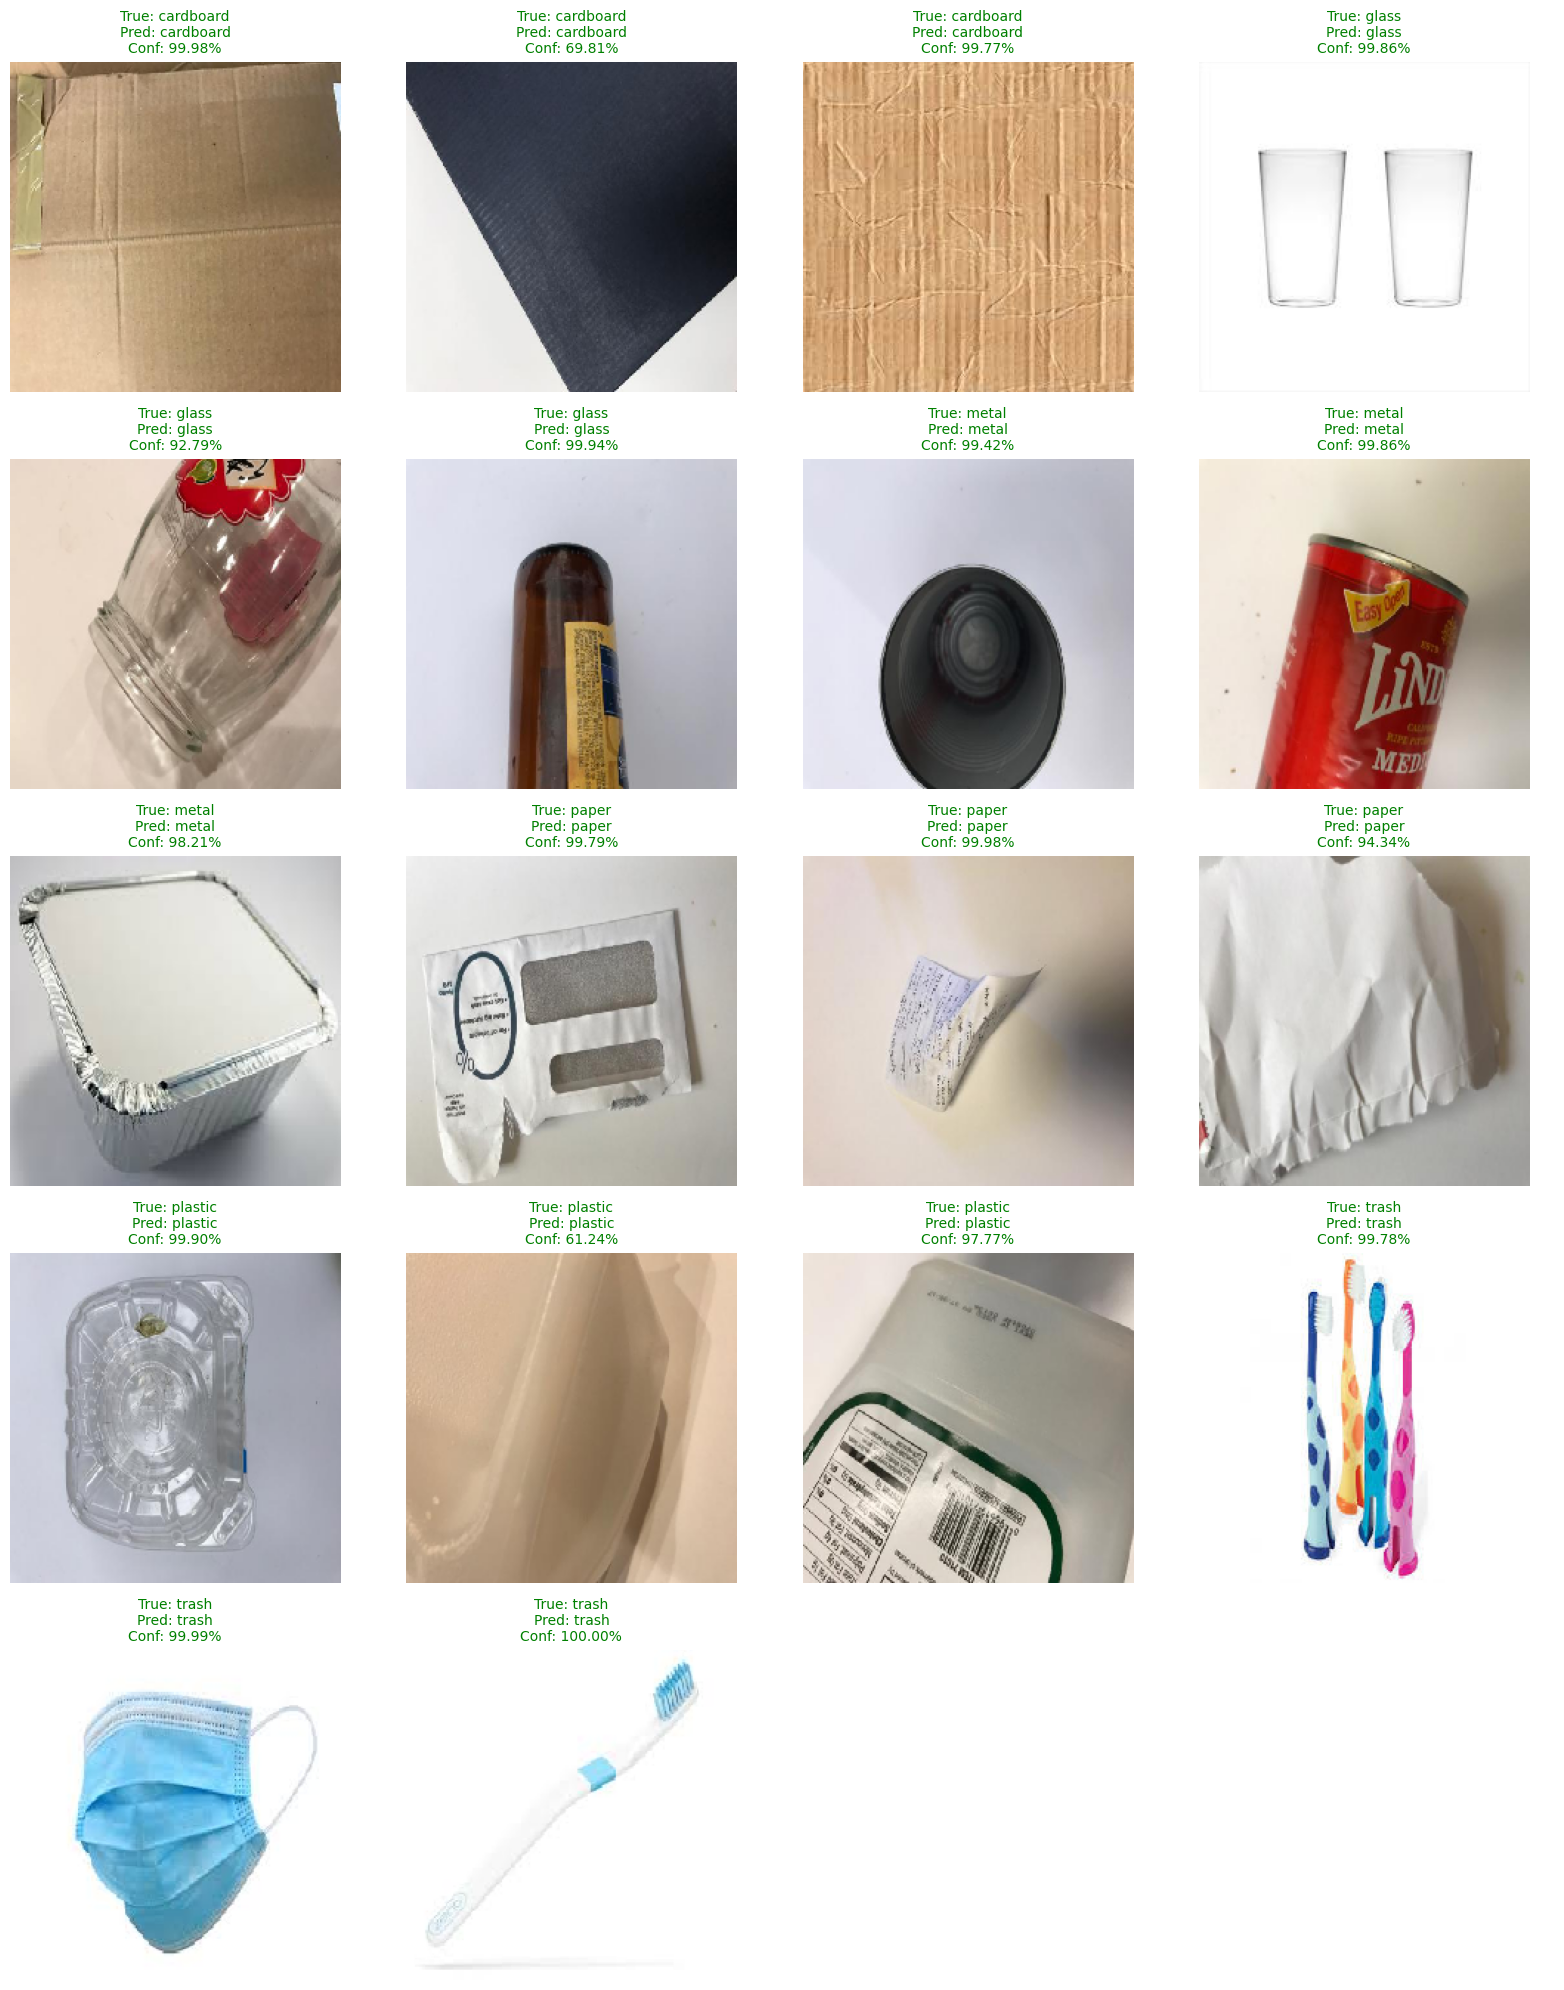


Batch Prediction Summary:
Total images: 18
Correct predictions: 18
Accuracy: 100.00%

2️ Analyzing Prediction Confidence...


<ipython-input-38-44a42ea638cf>:48: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



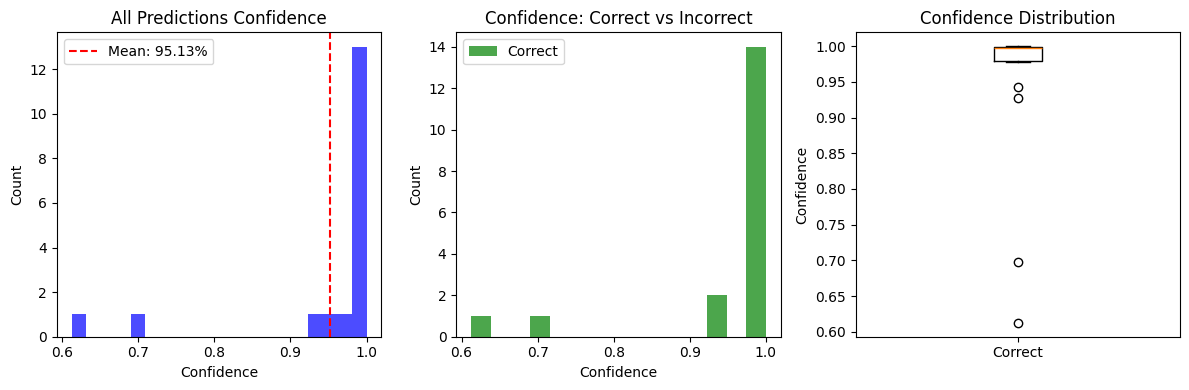


Confidence Analysis:
Average confidence (all): 95.13%
Average confidence (correct): 95.13%

3️ Evaluating Class-wise Performance...


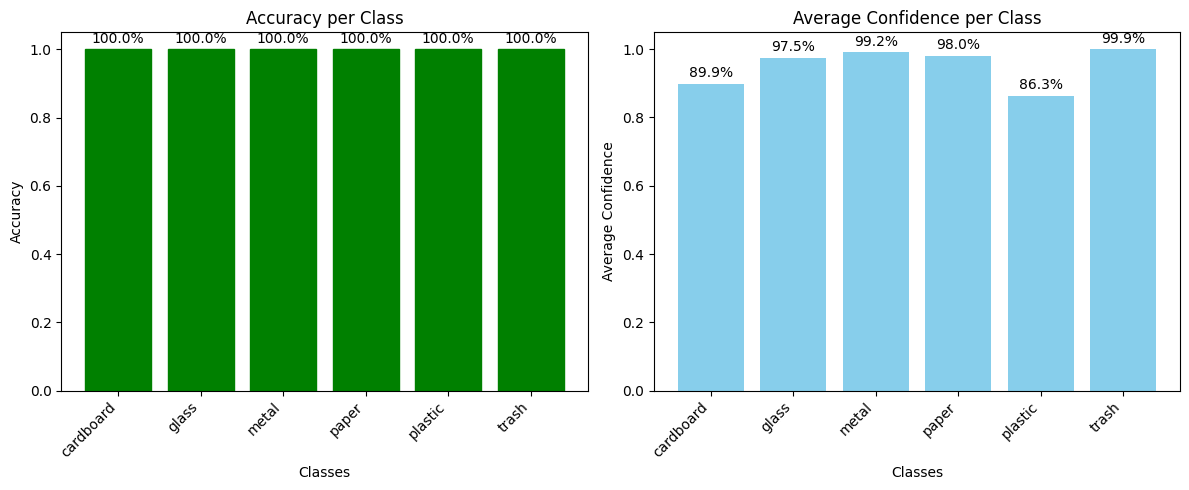


Class-wise Performance:
------------------------------------------------------------
cardboard       | Accuracy: 100.0% | Confidence: 89.9% | Samples:  3
glass           | Accuracy: 100.0% | Confidence: 97.5% | Samples:  3
metal           | Accuracy: 100.0% | Confidence: 99.2% | Samples:  3
paper           | Accuracy: 100.0% | Confidence: 98.0% | Samples:  3
plastic         | Accuracy: 100.0% | Confidence: 86.3% | Samples:  3
trash           | Accuracy: 100.0% | Confidence: 99.9% | Samples:  3

 All experiments completed!
📋 Experiment functions sukses!
Use run_comprehensive_experiments() to start testing your model.


In [ ]:
# ============================================================================
# CARA PENGGUNAAN MENGGUNAKAN MODEL FINE-TUNING
# ============================================================================

import random

# 1. Load your trained model
model = tf.keras.models.load_model('training/best_model_finetuning.h5')

# 2. Define class names (should match your training data)
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# 3. Define test directory
test_dir = 'dataset-split/test'

# 4. Run comprehensive experiments
results = run_comprehensive_experiments(model, test_dir, class_names, n_samples=3)


print("📋 Experiment functions sukses!")
print("Use run_comprehensive_experiments() to start testing your model.")